In [1]:
import sys, os
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapl'] + '/azav')

import numpy as np
import scipy as sp
import pickle

import matplotlib.pyplot as plt

%matplotlib inline

from azav_util import *
from plotcommon import *
from common import *

In [2]:
# Get Rachel's solar data
di = get_dict('gongdata/avgong1995-2009rls.pkl')
di.keys()

dict_keys(['om', 'om_err', 'nt', 'nr', 'tt', 'rr', 'sint', 'cost', 'rr_2d', 'tt_2d', 'sint_2d', 'cost_2d', 'xx', 'zz'])

In [22]:
# read in model S
fname = os.environ['notes'] + '/Model_S/Model_S.pkl'
model_S = get_dict(fname)
model_S.keys()

dict_keys(['msun', 'rsun', 'lsun', 'zsun', 'x0sun', 'alphasun', 'agesun', 'rr', 'lnq', 'grav', 'tmp', 'prs', 'rho', 'xfrac', 'lum', 'opa', 'eps', 'gamma', 'gamma_ad', 'delta', 'c_p', 'mue', 'ne', 'dsdr', 'nsq', 'zfrac', 'nu', 'kappa', 'eta', 'prm', 'pr', 'drhodr', 'dtmpdr', 'dprsdr', 'dlnrho', 'dlntmp', 'dlnprs', 'gas_constant', 'ircut', 'rcut', 'irbcz', 'rbcz', 'frad', 'heat', 'rtach', 'dtach', 'irtach', 'irtach1', 'irtach2', 'rtach1', 'rtach2'])

In [24]:
# cut the data off below 0.5*rsun (like in Rachel's plot)
rbot = 0.5*model_S['rsun']

In [27]:
print("common:  ", rsun)
print("model S: ", model_S['rsun'])
print("GONG   : ", np.max(di['rr']))

common:   69570000000.0
model S:  69599062580.0
GONG   :  1.00071


In [28]:
# they're a bit different... use model_S rsun for consistency
rsun = model_S['rsun']

In [29]:
# diffrot in "lab" frame
Om_nhz = di['om']
Om_err_nhz = di['om_err']

Om = Om_nhz*1e-9*(2*np.pi) # nHz --> rad/s

nt = di['nt']
nr = di['nr']

tt = di['tt']
rr = di['rr']*rsun

cost = di['cost']
sint = di['sint']

cost_2d = di['cost_2d']
sint_2d = di['sint_2d']

rr_2d = di['rr_2d']*rsun

xx = di['xx']
zz = di['zz']

In [30]:
# make sure all the shapes and ordering (decreasing coordinates)
# is hunky-dory

In [31]:
print(np.shape(Om))
print(np.shape(tt))
print(np.shape(rr))
print(tt[1]-tt[0])
print(rr[1]-rr[0])
print(np.min(tt), np.min(tt))

(41, 38)
(41,)
(38,)
-0.032729999999999926
-17399765.645004272
0.261799 0.261799


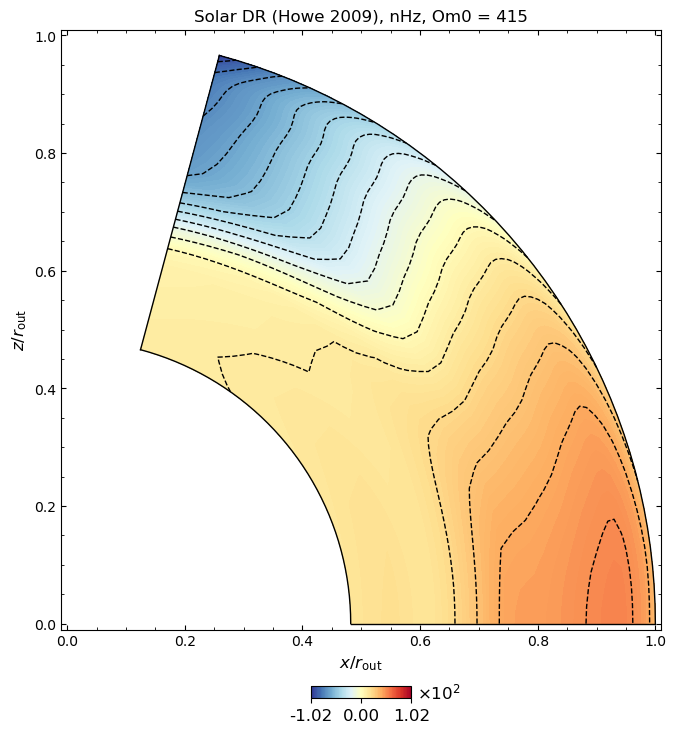

In [32]:
# plot the DR to make sure it looks good
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 6, 'ncontours': 20, 'plotcontours': True})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]

Om0 = 415
plot_azav (Om/(2*np.pi)*1e9-Om0, rr, cost, fig, ax, **kw_plot_azav)

ax.set_title("Solar DR (Howe 2009), nHz, Om0 = %i" %Om0)
plt.savefig('images/solar_diffrot.png', dpi=300)

In [33]:
# get rotation rate derivatives
dOmdr = np.gradient(Om, rr, axis=1)
dOmdt = np.gradient(Om, tt, axis=0)/rr_2d
dOmdz = cost_2d*dOmdr - sint_2d*dOmdt
dOmdl = sint_2d*dOmdr + cost_2d*dOmdt

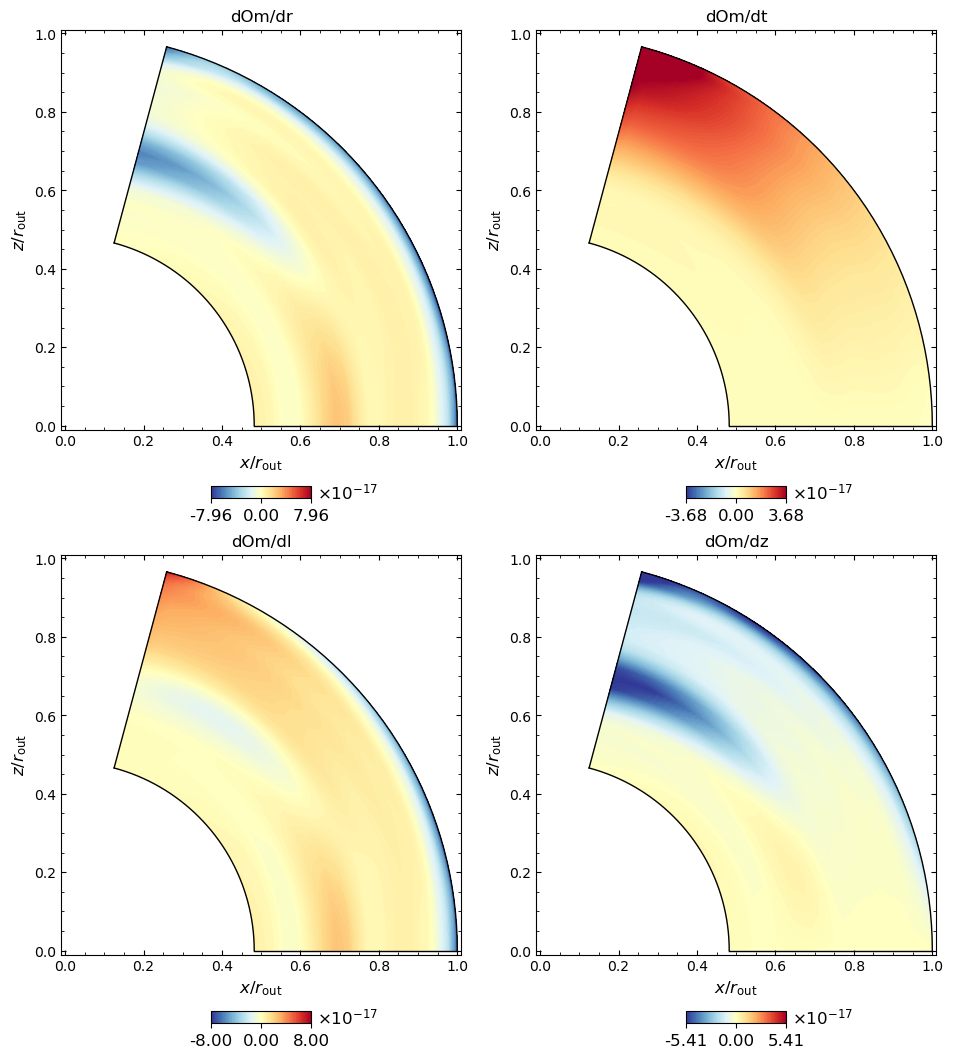

In [34]:
# plot DR derivatives

# specify any particular "command line arguments" here
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 4, 'ncontours': 20,
                     'nplots': 4, 'ncol': 2, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)

plot_azav (dOmdr, rr, cost, fig, axs[0,0], **kw_plot_azav)
plot_azav (dOmdt, rr, cost, fig, axs[0, 1], **kw_plot_azav)
plot_azav (dOmdl, rr, cost, fig, axs[1,0], **kw_plot_azav)
plot_azav (dOmdz, rr, cost, fig, axs[1, 1], **kw_plot_azav)

axs[0,0].set_title('dOm/dr')
axs[0,1].set_title('dOm/dt')
axs[1,0].set_title('dOm/dl')
axs[1,1].set_title('dOm/dz')

plt.savefig('images/solar_diffrot_derivs.png', dpi=300)

In [35]:
# interpolate model S onto radial grid

In [36]:
rr_model_S = model_S['rr']

y = model_S['grav']
f = sp.interpolate.interp1d(rr_model_S, y)
grav = f(rr)

y = model_S['c_p']
f = sp.interpolate.interp1d(rr_model_S, y)
c_p = f(rr)

y = model_S['tmp']
f = sp.interpolate.interp1d(rr_model_S, y)
tmp = f(rr)

y = model_S['rho']
f = sp.interpolate.interp1d(rr_model_S, y)
rho = f(rr)

y = model_S['delta'] # -dlnrho/dlntmp
f = sp.interpolate.interp1d(rr_model_S, y)
delta = f(rr)

(0.0, 1600000000.0)

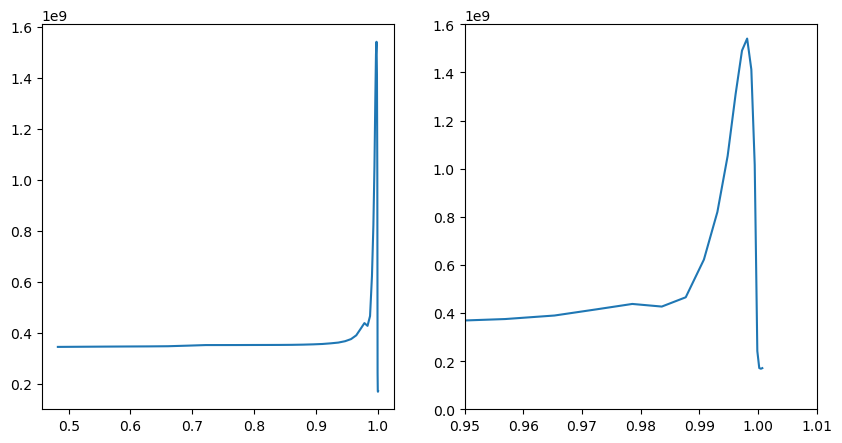

In [37]:
# plot variation in c_P
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(rr/rsun, c_p)

axs[1].plot(rr/rsun, c_p)
axs[1].set_xlim(0.95, 1.01)
axs[1].set_ylim(0, 1.6e9)
#axs[1].set_yscale('log')

(0.0, 2.3)

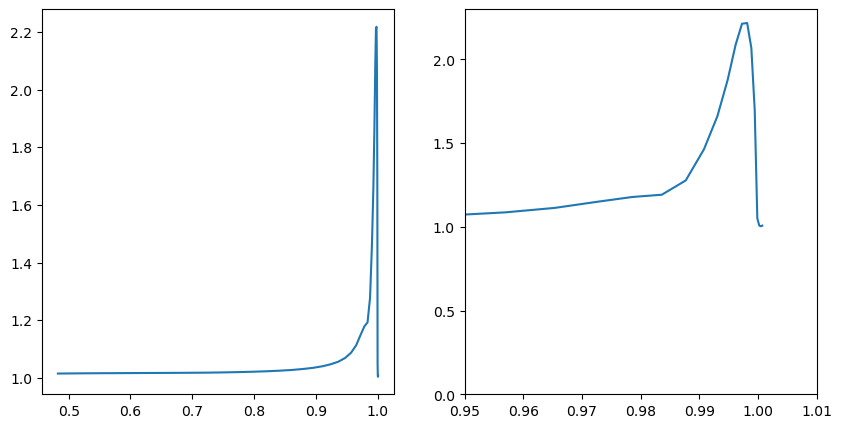

In [38]:
# plot variation in beta_T
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(rr/rsun, delta)

axs[1].plot(rr/rsun, delta)
axs[1].set_xlim(0.95, 1.01)
axs[1].set_ylim(0, 2.3)
#axs[1].set_yscale('log')

(0.0, 6e-09)

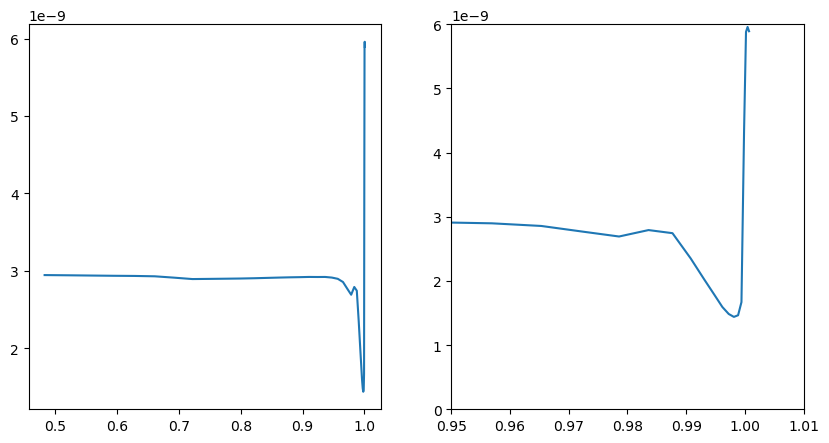

In [39]:
# plot beta_T/c_p that appears in thermal wind
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(rr/rsun, delta/c_p)

axs[1].plot(rr/rsun, delta/c_p)
axs[1].set_xlim(0.95, 1.01)
axs[1].set_ylim(0,6e-9)
#axs[1].set_yscale('log')

In [40]:
# OK, so this stuff really ldoesn't matter except for r > 0.985 rsun

In [41]:
# compute the thermal wind
rhs = (1./grav).reshape((1, nr)) * rr_2d**2*sint_2d * (2*Om*dOmdz)

def integrate_from_equator(arr):
    int_arr = np.zeros((nt, nr))
    for it in range(nt):
        int_arr[it, :] = np.trapz(arr[:it+1, :], tt[:it+1], axis=0)
    return int_arr

s_dev_nd = 1./delta.reshape((1, nr)) * integrate_from_equator(rhs)

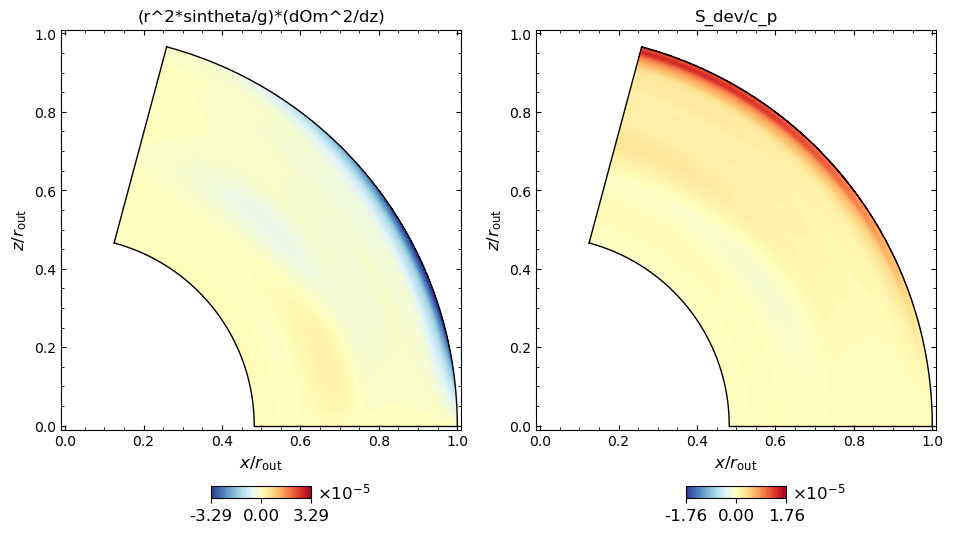

In [42]:
# plot DR derivatives, x r sin theta

# specify any particular "command line arguments" here
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 4, 'ncontours': 20,
                     'nplots': 2, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)

plot_azav (rhs, rr, cost, fig, axs[0,0], **kw_plot_azav)
#kw_plot_azav.minmax = -1e-5, 1e-5
plot_azav (s_dev_nd, rr, cost, fig, axs[0, 1], **kw_plot_azav)

axs[0,0].set_title('(r^2*sintheta/g)*(dOm^2/dz)')
axs[0,1].set_title('S_dev/c_p')

plt.savefig('images/solar_dOm2_sdev.png', dpi=300)

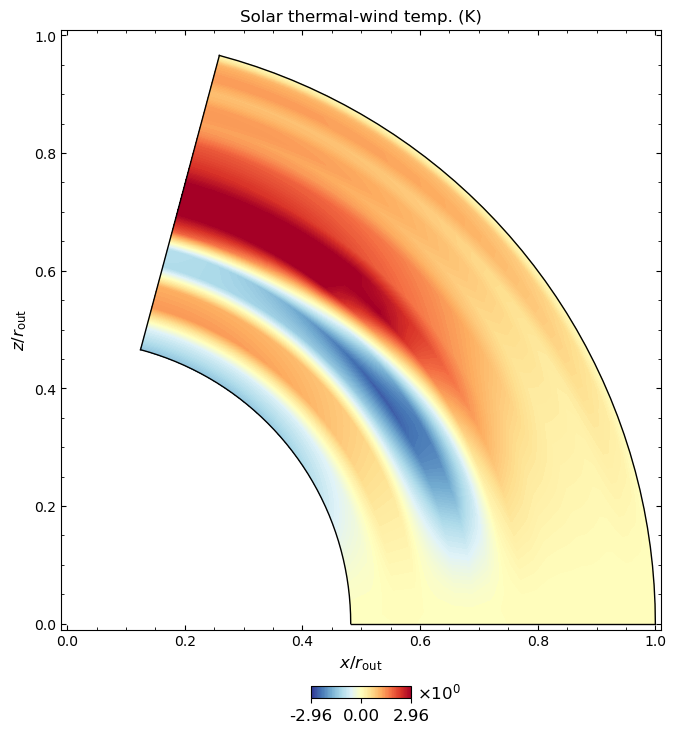

In [43]:
# compute and plot the temperature deviation (in units)
t_dev_nd = 1./delta.reshape((1, nr)) * integrate_from_equator(rhs)
t_dev = t_dev_nd * tmp.reshape((1, nr))


notebook_clas = dict({'halfplane': True, 'sub_width_inches': 6, 'ncontours': 20, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]

plot_azav (t_dev, rr, cost, fig, ax, **kw_plot_azav)

ax.set_title("Solar thermal-wind temp. (K)")

plt.savefig('images/solar_TW_temp.png', dpi=300)

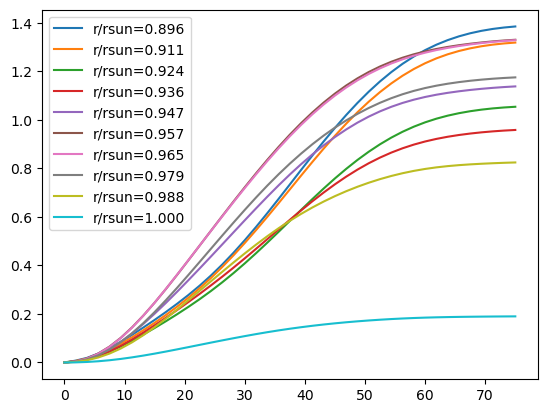

In [47]:
# plot T(theta) at different levels in NSSL
r1 = 0.9*rsun
r2 = rsun
nlevs = 10
rvals = np.linspace(r1, r2, nlevs)
irvals = inds_from_vals(rr, rvals)
rvals_actual = rr[irvals]

def volav_coloc(arr, r1, r2):
    ir1, ir2 = inds_from_vals(rr, [r1, r2])
    arr_loc = arr[:, ir2:ir1+1]
    dr = -np.diff(rr)
    dr_ext = np.array(list(dr) + [dr[-1]])
    dr_loc = dr_ext[ir2:ir1+1]
    rr_loc = rr[ir2:ir1+1]
    rw = rr_loc**2*dr_loc
    nrloc = len(rw)
    return np.sum(arr_loc*rw.reshape((1,nrloc)), axis=1)/np.sum(rw)

tt_lat = 180.0/np.pi*(np.pi/2 - tt)


for ir in range(nlevs):
    rval_act = rvals_actual[ir]/rsun
    irval = irvals[ir]
    
    plt.plot(tt_lat, t_dev[:, irval], label='r/rsun=%.3f' %rval_act)
plt.legend()

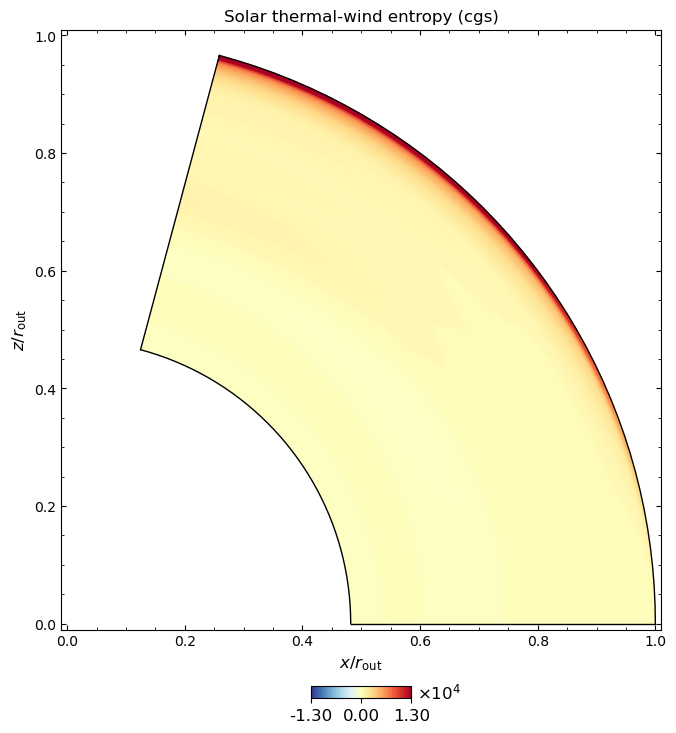

In [46]:
# plot the entropy deviation (in units)
s_dev = s_dev_nd * c_p.reshape((1, nr))

notebook_clas = dict({'halfplane': True, 'sub_width_inches': 6, 'ncontours': 20, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]

plot_azav (s_dev, rr, cost, fig, ax, **kw_plot_azav)

ax.set_title("Solar thermal-wind entropy (cgs)")

plt.savefig('images/solar_TW_entropy.png', dpi=300)

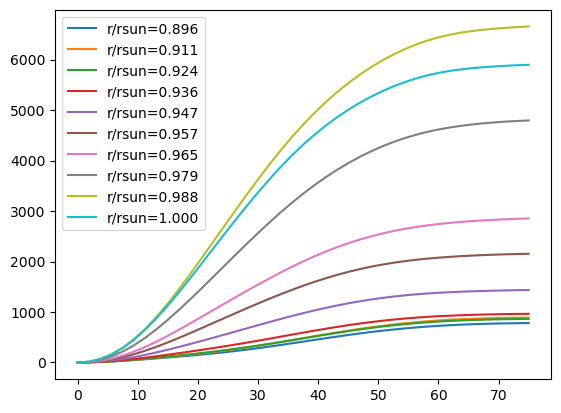

In [48]:
# plot S(theta) at different levels in NSSL
r1 = 0.9*rsun
r2 = rsun
nlevs = 10
rvals = np.linspace(r1, r2, nlevs)
irvals = inds_from_vals(rr, rvals)
rvals_actual = rr[irvals]


for ir in range(nlevs):
    rval_act = rvals_actual[ir]/rsun
    irval = irvals[ir]
    
    plt.plot(tt_lat, s_dev[:, irval], label='r/rsun=%.3f' %rval_act)
plt.legend()

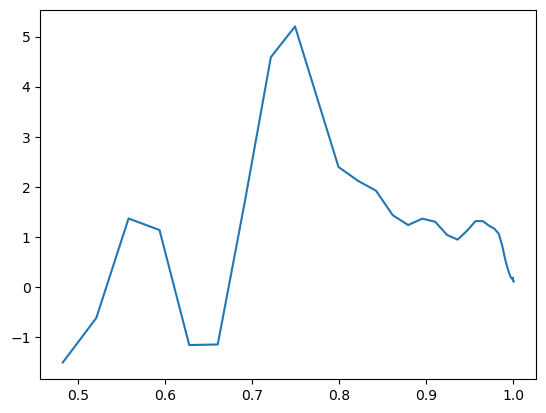

In [51]:
# compare to Jha 2021 by plotting difference in temp. between 20 degrees colatitude and 
# equator as fct of radius

it1, it2 = inds_from_vals(tt_lat, [0., 70.])
delta_t = t_dev[it2, :] - t_dev[it1, :]
plt.plot(rr/rsun, delta_t)

(0.0, 6.0)

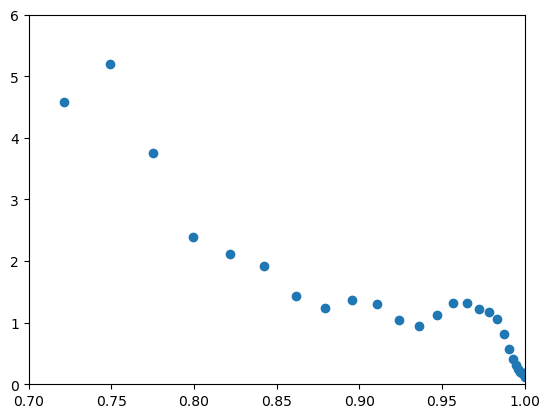

In [56]:
# focus on the CZ
plt.scatter(rr/rsun, delta_t)
plt.xlim(0.7, 1)
plt.ylim(0, 6)

(0.0, 10.0)

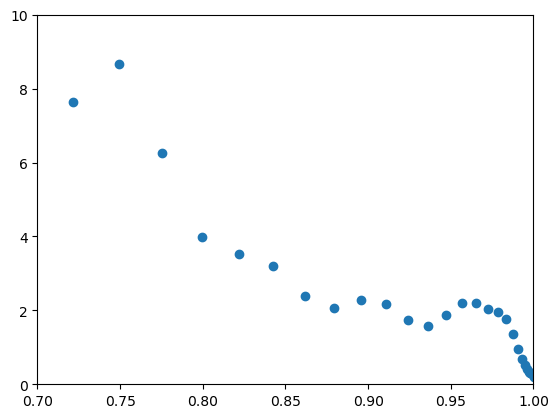

In [58]:
# now instead compute t_dev_wrong (gamma * T_bar * t_dev_nond) to compare to Choudhuri
t_dev_wrong = 5./3.*t_dev_nd * tmp.reshape((1, nr))
delta_t_wrong = t_dev_wrong[it2, :] - t_dev_wrong[it1, :]
plt.scatter(rr/rsun, delta_t_wrong)
plt.xlim(0.7, 1)
plt.ylim(0, 10)

In [62]:
# let's compute Z, the variation in dOm^2/dz
Z = Om/(2*dOmdz)
Z

array([[ 6.28101305e+12,  6.28375155e+12,  6.23796458e+12, ...,
        -7.77903703e+13, -8.61497582e+13, -1.28181345e+14],
       [-7.41664514e+11, -7.51392829e+11, -7.62353251e+11, ...,
        -1.21039230e+13,  1.25329876e+13,  6.66726674e+12],
       [-3.36958808e+11, -3.40974212e+11, -3.45722286e+11, ...,
        -5.99760451e+12,  6.34462351e+12,  3.35622875e+12],
       ...,
       [-1.65791375e+10, -1.67146980e+10, -1.69076202e+10, ...,
        -4.67322506e+11, -8.52582767e+11, -3.85099595e+12],
       [-1.39272961e+10, -1.40588972e+10, -1.42236632e+10, ...,
        -4.69344427e+11, -8.11236030e+11, -2.92549144e+12],
       [-1.17753756e+10, -1.18826182e+10, -1.20114277e+10, ...,
        -4.68430052e+11, -7.70901763e+11, -2.37263580e+12]])

Text(0.5, 1.0, 'Thermal-Wind lengthscale Z')

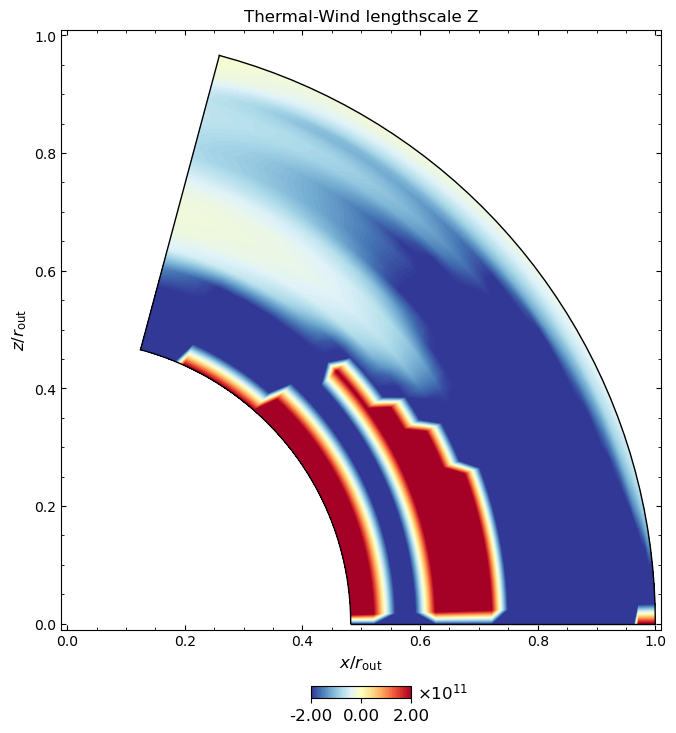

In [65]:
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 6, 'ncontours': 20, 'plotcontours': False,
                     'minmax':(-2e11, 2e11)})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]

plot_azav (Z, rr, cost, fig, ax, **kw_plot_azav)

ax.set_title("Thermal-Wind lengthscale Z")

#plt.savefig('images/solar_TW_temp.png', dpi=300)

(0.7, 1.0)

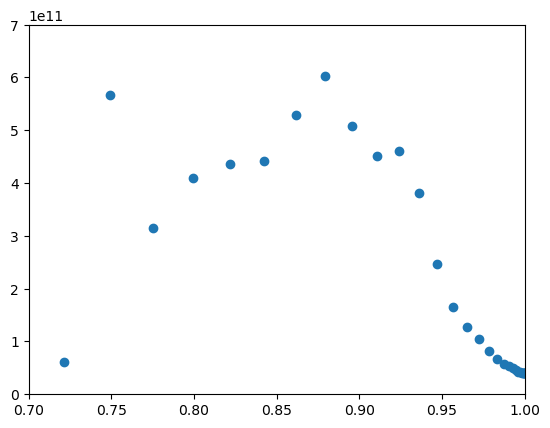

In [74]:
# Let's average between 10 and 60 degrees and plot vs radius, ignore tachocline
it1, it2 = inds_from_vals(tt_lat, [10., 60.])
Z_vsr = np.mean(Z[it1:it2+1, :], axis=0)

plt.scatter(rr/rsun, np.abs(Z_vsr))
plt.ylim(0, 7e11)
plt.xlim(0.7,1)